In [43]:
import config_readwrite as crw
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import pandas as pd

from scipy import stats
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

# params

In [4]:
CL = "hepg2"
PREFIX = "reg.all"
DATA_PATH = f"/wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/deepstarr/deseq2/{CL}/{PREFIX}"
DATA_PATH_NOT_SCALED = f"/wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/deepstarr/deseq2/{CL}/reg.all.not_scaled.50epochs"

In [44]:
os.chdir(DATA_PATH)

# load predictions
PRED = f'DeepSTARR_ATAC.{PREFIX}.test.predictions.tsv'
TEST = f"{PREFIX}.Sequences_activity_Test.txt"
DIFF_ACC = f"/wynton/group/ahituv/data/US-MPRA/ATAC-seq/Diffbind_results/{CL}_deseq2-nondiff.in.diffAcc.bed"
TEST_CHR = "chr8"

SCALED = False

# load data

## predictions

In [12]:
pred = pd.read_csv(PRED, sep='\t')
print(pred.shape)
pred.head()

(4755, 2)


,pred_US,pred_ctrl
0,1.451654,1.429607
1,2.464733,2.523003
2,1.055604,0.930951
3,5.062998,5.052336
4,2.320867,2.414048


## test data

In [16]:
test = pd.read_csv(TEST, sep='\t')
test["type"] = test["coor.type"].apply(lambda x: x.split("|")[0])

print(test.shape)
test.head()

(4755, 4)


,coor.type,US,ctrl,type
0,hepg2.71089|chr8:82925501-82925772,1.019027,0.466838,hepg2.71089
1,hepg2.61844|chr8:133886145-133886416,1.383546,1.882701,hepg2.61844
2,hepg2.25924|chr8:26182963-26183234,0.000000,0.861839,hepg2.25924
3,hepg2.80172|chr8:144358418-144358689,4.608091,4.427402,hepg2.80172
4,hepg2.104271|chr8:125729556-125729827,0.792896,0.979248,hepg2.104271


In [48]:
if SCALED is True:
    sc = StandardScaler()
    test_scaled = pd.DataFrame(sc.fit_transform(test[["US", "ctrl"]].copy()), 
                              columns = ['US_scaled', "ctrl_scaled"])
    
    test_scaled = pd.merge(test, test_scaled, left_index=True, right_index=True)

test_scaled

,coor.type,US,ctrl,type,US_scaled,ctrl_scaled
0,hepg2.71089|chr8:82925501-82925772,1.019027,0.466838,hepg2.71089,-0.924061,-1.248042
1,hepg2.61844|chr8:133886145-133886416,1.383546,1.882701,hepg2.61844,-0.693572,-0.374312
2,hepg2.25924|chr8:26182963-26183234,0.000000,0.861839,hepg2.25924,-1.568402,-1.004287
3,hepg2.80172|chr8:144358418-144358689,4.608091,4.427402,hepg2.80172,1.345341,1.196027
4,hepg2.104271|chr8:125729556-125729827,0.792896,0.979248,hepg2.104271,-1.067046,-0.931834
...,...,...,...,...,...,...
4750,hepg2.5034|chr8:68183421-68183692,0.000000,1.873975,hepg2.5034,-1.568402,-0.379696
4751,hepg2.112724|chr8:143437536-143437807,2.132980,2.299085,hepg2.112724,-0.219697,-0.117361
4752,hepg2.59149|chr8:122678857-122679128,1.469412,2.051428,hepg2.59149,-0.639278,-0.270190
4753,hepg2.13539|chr8:6616581-6616852,1.469412,0.000000,hepg2.13539,-0.639278,-1.536129


## merge all data

In [22]:
pt = pd.merge(test, pred, left_index=True, right_index=True)
pt["diff_acc"]=False

In [ ]:
sns.jointplot(x="US", y="pred_US", data=pt, kind="hex")

In [ ]:
dif_acc = pd.read_csv(DIFF_ACC, sep='\t', header=None, 
                      names=["#chr_da", "start_da", "end_da", "id_da", 
                      "#chr_peak","start_peak", "end_peak", "type" ]
                     )
# get true differentially accessible peaks 
test_dif_acc = set(dif_acc.loc[dif_acc["#chr_peak"] == TEST_CHR, "type"])

# annotate ids that are differentially accessible according to DESEQ2
pt.loc[pt["type"].isin(test_dif_acc), "diff_acc"] = True

In [49]:
len(test_dif_acc)

57

## compute score differences

In [28]:
pt["ctrl-us"]= pt["ctrl"] - pt["US"]
pt["pred_ctrl-pred_us"]= pt["pred_ctrl"] - pt["pred_US"]

## correlation between predictions

In [29]:
pt.corr()

,US,ctrl,pred_US,pred_ctrl,diff_acc,ctrl-us,pred_ctrl-pred_us
US,1.000000,0.918129,0.619501,0.618458,-0.020169,-0.144374,0.115769
ctrl,0.918129,1.000000,0.623408,0.624806,-0.023761,0.259577,0.164135
pred_US,0.619501,0.623408,1.000000,0.998730,-0.004178,0.046964,0.194919
pred_ctrl,0.618458,0.624806,0.998730,1.000000,-0.004403,0.052994,0.244078
diff_acc,-0.020169,-0.023761,-0.004178,-0.004403,1.000000,-0.010179,-0.005293
ctrl-us,-0.144374,0.259577,0.046964,0.052994,-0.010179,1.000000,0.127723
pred_ctrl-pred_us,0.115769,0.164135,0.194919,0.244078,-0.005293,0.127723,1.000000


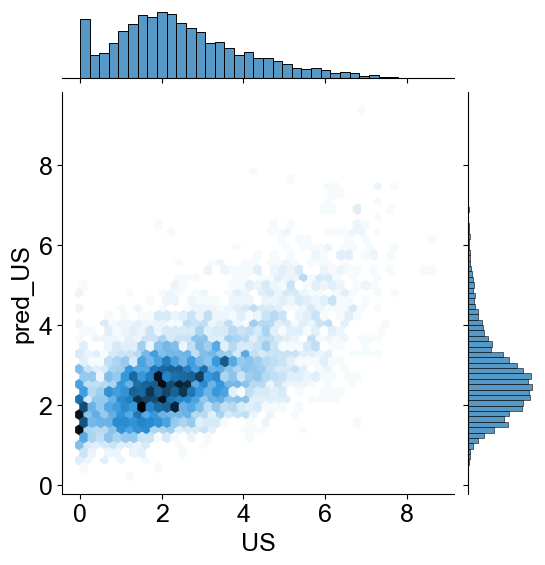

In [30]:
sns.jointplot(x="US", y="pred_US", data=pt, kind="hex")

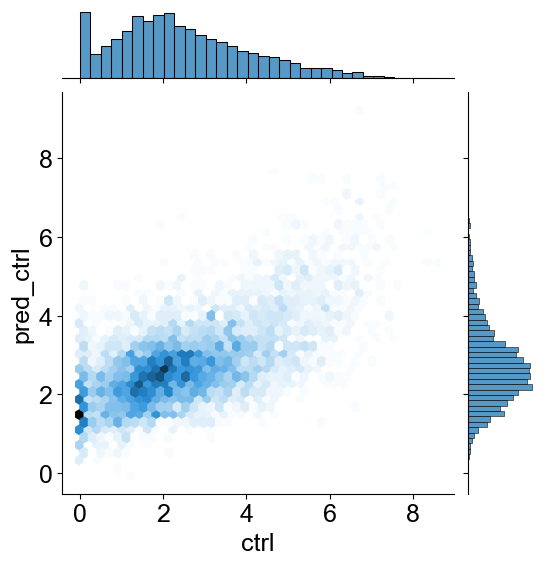

In [34]:
sns.jointplot(x="ctrl", y="pred_ctrl", data=pt, kind="hex")

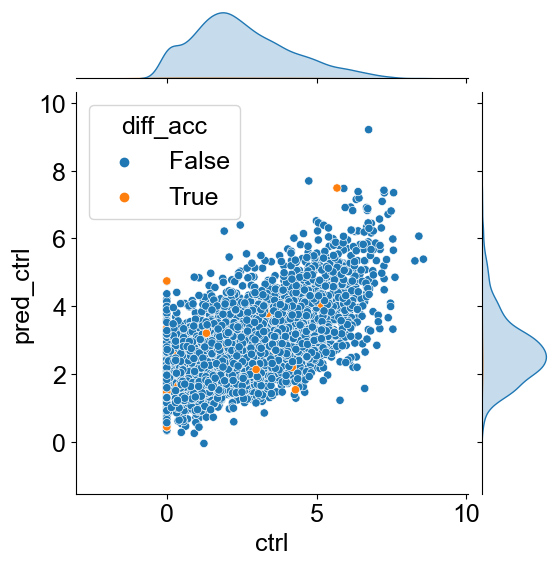

In [35]:
sns.jointplot(x="ctrl", y="pred_ctrl", data=pt, hue="diff_acc")

<AxesSubplot:xlabel='ctrl-us', ylabel='pred_ctrl-pred_us'>

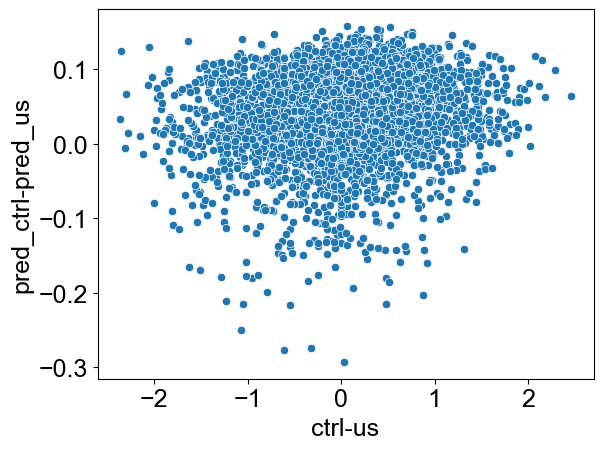

In [37]:
x = "ctrl-us"
y = "pred_ctrl-pred_us"
sns.scatterplot(x=x,y=y, data=pt)

## evaluate diff accessible

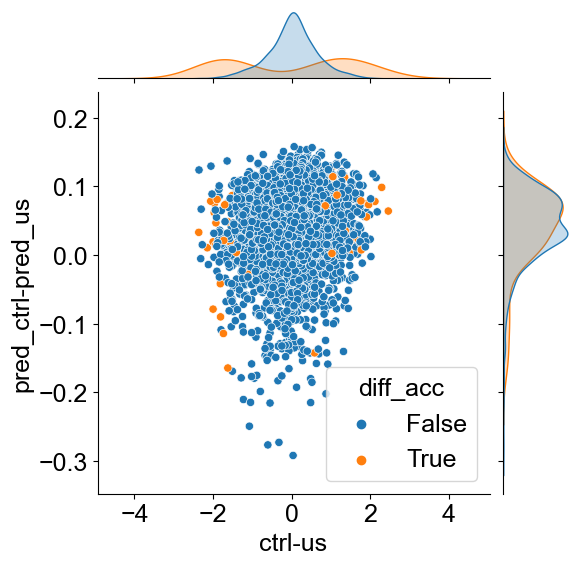

In [41]:
sns.jointplot(x=x,y=y, data=pt, hue="diff_acc", marginal_kws={"common_norm":False})

In [42]:
pt.loc[pt["diff_acc"]==True].corr()

,US,ctrl,pred_US,pred_ctrl,diff_acc,ctrl-us,pred_ctrl-pred_us
US,1.000000,0.537837,0.365936,0.363919,NaN,-0.251713,0.012934
ctrl,0.537837,1.000000,0.450327,0.465572,NaN,0.680524,0.323280
pred_US,0.365936,0.450327,1.000000,0.998353,NaN,0.198917,0.102350
pred_ctrl,0.363919,0.465572,0.998353,1.000000,NaN,0.218171,0.159253
diff_acc,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ctrl-us,-0.251713,0.680524,0.198917,0.218171,NaN,1.000000,0.359878
pred_ctrl-pred_us,0.012934,0.323280,0.102350,0.159253,NaN,0.359878,1.000000


In [50]:
pt.loc[pt["diff_acc"]==True].corr(method="spearman")

,US,ctrl,pred_US,pred_ctrl,diff_acc,ctrl-us,pred_ctrl-pred_us
US,1.000000,0.476403,0.252747,0.257095,NaN,-0.371045,0.083892
ctrl,0.476403,1.000000,0.410381,0.421547,NaN,0.612169,0.390595
pred_US,0.252747,0.410381,1.000000,0.997926,NaN,0.175495,0.396033
pred_ctrl,0.257095,0.421547,0.997926,1.000000,NaN,0.183274,0.427534
diff_acc,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ctrl-us,-0.371045,0.612169,0.175495,0.183274,NaN,1.000000,0.307692
pred_ctrl-pred_us,0.083892,0.390595,0.396033,0.427534,NaN,0.307692,1.000000


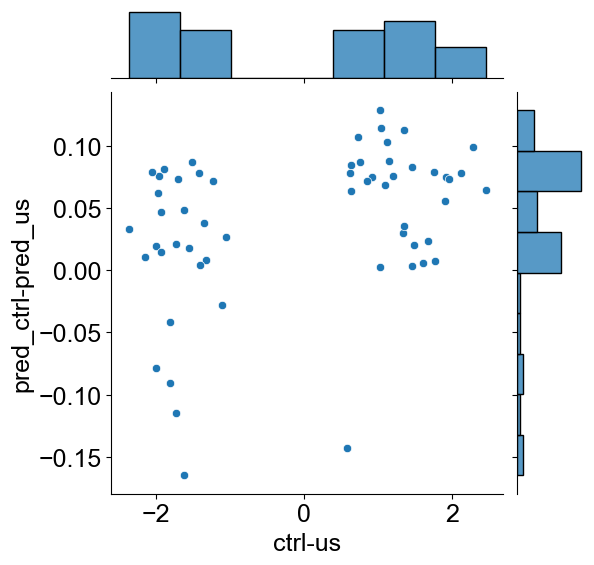

In [51]:
sns.jointplot(x=x,y=y, data=pt.loc[pt["diff_acc"]==True], marginal_kws={"common_norm":False})